<a href="https://colab.research.google.com/github/Themanwhosoldtheworldd/Project-Moriarty/blob/main/Moriarty_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Moriarty**
The project's goal in this state, is to take user input using the default system microphone and transcode the speech to text. After that a model (unitaryai/detoxify) is used to classify the text produced from whisper as **toxic**,   **severe_toxic**,   **obscene**,   **threat**,   **insult**, **identity_atttack**.


# **Prerequisites**

In [168]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
!pip install git+https://github.com/openai/whisper.git 
!pip install git+https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt
!pip install git+https://github.com/unitaryai/detoxify/releases/download/v0.4-alpha/multilingual_debiased-0b549669.ckpt
!pip install git+https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt
!pip install git+https://github.com/unitaryai/detoxify/releases/download/v0.3-alpha/toxic_debiased-c7548aa0.ckpt

!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pyaudio
!pip install Numpy as np
!pip install ffmpeg-python
!pip install transformers
!pip install detoxify
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-zjclzru4
  Running command git clone -q https://github.com/openai/whisper.git /tmp/pip-req-build-zjclzru4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt to /tmp/pip-req-build-7dysbs9w
  Running command git clone -q https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt /tmp/pip-req-build-7dysbs9w
  remote: Not Found
  fatal: repository 'https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt/' not found
ERROR: Command errored out with exit status 12

In [169]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
import scipy
import whisper
import os
import torch
from detoxify import Detoxify
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd


# **Whisper for audio transcode**

Here it is essential that a cuda-enabled GPU is utilized otherwise the process is going to be very slow. If you are using the CPU it is strongly advised that you use "tiny" model for whisper

## Available models and languages

There are five model sizes, four with English-only versions, offering speed and accuracy tradeoffs. Below are the names of the available models and their approximate memory requirements and relative speed. 


|  Size  | Parameters | English-only model | Multilingual model | Required VRAM | Relative speed |
|:------:|:----------:|:------------------:|:------------------:|:-------------:|:--------------:|
|  tiny  |    39 M    |     `tiny.en`      |       `tiny`       |     ~1 GB     |      ~32x      |
|  base  |    74 M    |     `base.en`      |       `base`       |     ~1 GB     |      ~16x      |
| small  |   244 M    |     `small.en`     |      `small`       |     ~2 GB     |      ~6x       |
| medium |   769 M    |    `medium.en`     |      `medium`      |     ~5 GB     |      ~2x       |
| large  |   1550 M   |        N/A         |      `large`       |    ~10 GB     |       1x       |

In [170]:
torch.cuda.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [171]:
model = whisper.load_model("large",device=DEVICE)
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

Model is multilingual and has 1,541,384,960 parameters.


# **Voice Interface**

The code Below is mandatory if you are using colab. It creates an interface so the internet browser can access the microphone.

In [172]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

The code Below is used to generate a ".wav" file from the user's input, so that we can "feed" it to Whisper

In [173]:
def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

# Try it out


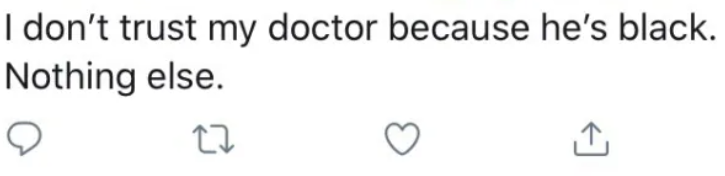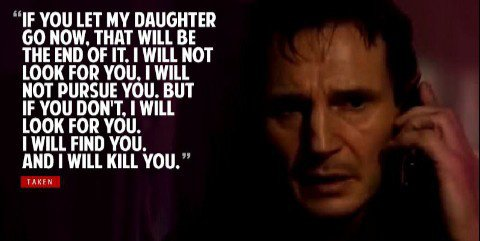

In [183]:
audio, sr = get_audio()

In [184]:
scipy.io.wavfile.write('recording.wav', sr, audio) 

# Language Detection


In [185]:
audio = whisper.load_audio("recording.wav")
audiotest = whisper.pad_or_trim(audio)
mel = whisper.log_mel_spectrogram(audiotest).to(model.device)

_, probs = model.detect_language(mel)
lg = max(probs, key=probs.get)
print(f"Detected language: {lg}")

Detected language: en


# **Detoxify Text-Classification Model**

Here we use Whisper's language translation capabilities in order to translate languages that aren't supported natively in 
detoxify model, so we can estimate hateful comments from other languages as well. Thus expanding Moriarty's accesibility options

In [186]:
# decode the audio
options = whisper.DecodingOptions()
#english, french, spanish, italian, portuguese, turkish or russian.
if lg=='en'or lg == 'fr'or lg=='es'or lg=='it'or lg=='tr'or lg=='ru'or lg=='pt':
  if lg == 'en':
      result = model.transcribe("recording.wav")
      print(result['text'])
      results = Detoxify('original').predict(result['text'])
  else:
    result = model.transcribe("recording.wav")
    result2 = model.transcribe("recording.wav",task='translate')
    print(result['text'])
    print(" English Translation:",result2['text'])
    results = Detoxify('multilingual').predict(result['text'])
else :
  result = model.transcribe("recording.wav",task='translate')
  print(result['text'])
  results = Detoxify('original').predict(result['text'])


 If you let my daughter go now, that will be the end of it. I will not look for you, I will not pursue you, but if you don't, I will look for you, I will find you, and I will kill you.


            toxicity  severe_toxicity  obscene   threat   insult  \
percentage   0.76012          0.04585  0.03293  0.78246  0.04291   

            identity_attack  
percentage          0.03036  


<function matplotlib.pyplot.show(*args, **kw)>

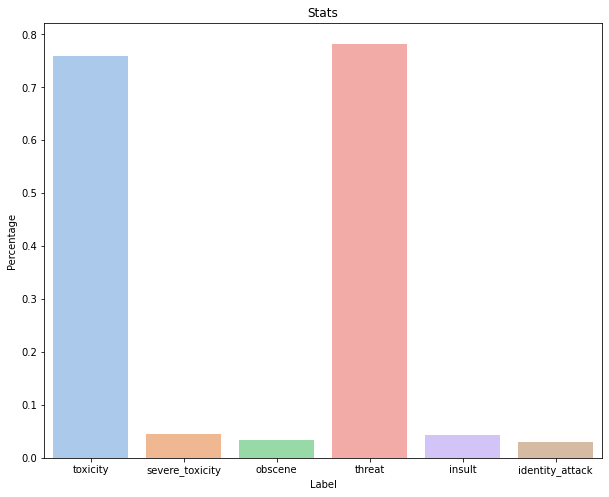

In [187]:

#each model takes in either a string or a list of strings
array = ["percentage"]
np.array(array)
df = pd.DataFrame(results, index=array)
print(pd.DataFrame(results, index=array).round(5))
plt.figure(figsize=(10,8))
sns.barplot(data=df,palette=sns.color_palette("pastel"))
plt.title('Stats')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.show


# **Credits**
Athanasiadou Christina, https://www.linkedin.com/in/christina-athanasiadou-37288a246

Chatzigeorgiou Spiros, https://www.linkedin.com/in/spiros-chatzigeorgiou-797148201/


**Technologies used:**

https://github.com/openai/whisper

https://github.com/unitaryai/detoxify